In [1]:
%matplotlib inline
import time
import numpy as np
import open3d as o3d
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from pyntcloud import PyntCloud
from open3d import JVisualizer
from pyquaternion import Quaternion
from torchvision import transforms

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.geometry_utils import transform_matrix, view_points
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud

In [2]:
dataset_path = 'D:\\Virtual Machines\\shared\\3d-object-detection-for-autonomous-vehicles\\'
dataset = LyftDataset(data_path=dataset_path, json_path=dataset_path + 'data', verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 16.1 seconds.
Reverse indexing ...
Done reverse indexing in 3.1 seconds.


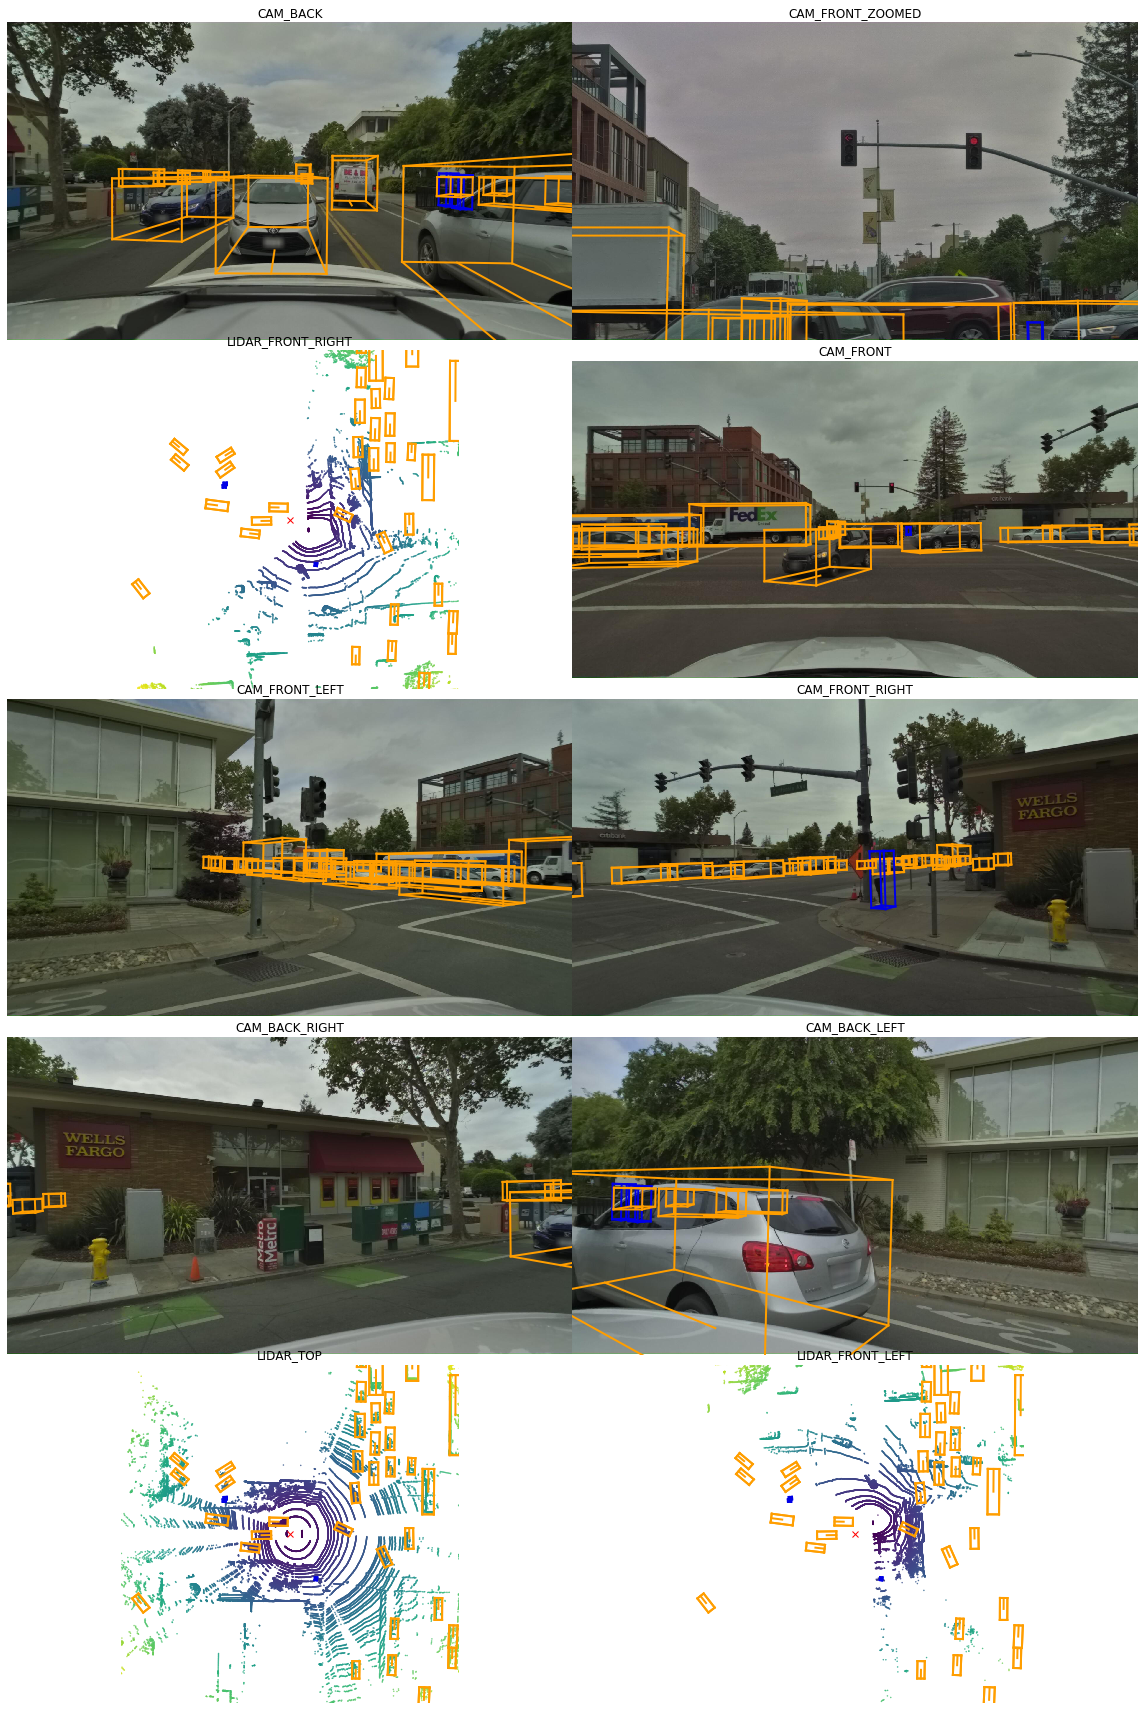

In [48]:
scene = dataset.scene[0]

sample_token = scene['first_sample_token']
sample = dataset.get('sample', sample_token)
dataset.render_sample(sample_token)

In [8]:
sd_lidar = dataset.get('sample_data', sample['data']['LIDAR_TOP'])
cs_lidar = dataset.get('calibrated_sensor', sd_lidar['calibrated_sensor_token'])

pc = LidarPointCloud.from_file(dataset.data_path / sd_lidar['filename'])
pc.points.shape

(4, 107845)

In [9]:
xyz = np.swapaxes(pc.points[:3, :], 0, 1)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)

In [10]:
#o3d.visualization.draw_geometries([pcd])

In [11]:
downpcd = pcd.voxel_down_sample(voxel_size=0.1)
#o3d.visualization.draw_geometries([downpcd])

(64768, 3)


(-50, 50)

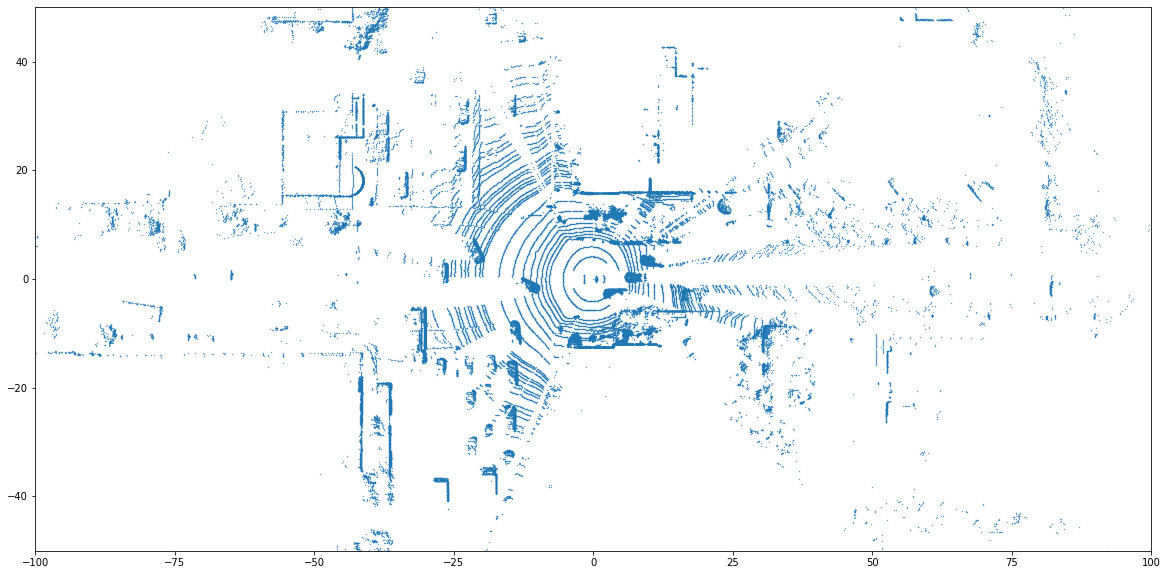

In [12]:
orig_poits = np.asarray(downpcd.points)
print(orig_poits.shape)

# Left is the front
_, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.scatter(orig_poits[:, 0], orig_poits[:, 1], s=0.1)
ax.set_xlim(-100, 100)
ax.set_ylim(-50, 50)

In [13]:
ego_pose = dataset.get('ego_pose', sd_lidar['ego_pose_token'])
ego_yaw = Quaternion(ego_pose['rotation']).yaw_pitch_roll[0] 
ego_yaw

-1.8535708966572233

In [14]:
cams = [
    'CAM_FRONT',
    'CAM_FRONT_LEFT',
    'CAM_FRONT_RIGHT',
    'CAM_BACK',
    'CAM_BACK_LEFT',
    'CAM_BACK_RIGHT'
]

for cam in cams:
    cam_token = sample['data'][cam]
    sd_cam = dataset.get('sample_data', cam_token)
    cs_cam = dataset.get('calibrated_sensor', sd_cam['calibrated_sensor_token'])
    
    ypr = Quaternion(cs_cam['rotation']).yaw_pitch_roll
    print(cam, ypr)

CAM_FRONT (-1.3100757931869385, 1.5445713092849767, -0.25643522925200024)
CAM_FRONT_LEFT (-0.028316582337274635, 0.5162372030469942, -1.553467667458523)
CAM_FRONT_RIGHT (-3.1081000997607524, 0.5273064380838608, 1.5589273249596833)
CAM_BACK (-1.7210802402061351, -1.5475389359993927, 2.9957796142551105)
CAM_BACK_LEFT (-0.03280066375013924, -0.5299422358852844, -1.5862834368466505)
CAM_BACK_RIGHT (-3.112095641468106, -0.5189168790726362, 1.5838680856837883)


(1920, 1080)


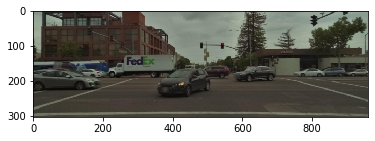

(1920, 1080)


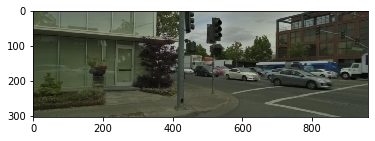

(1920, 1080)


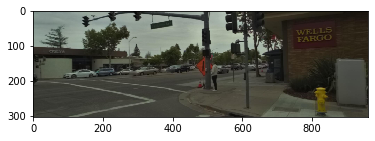

(1920, 1080)


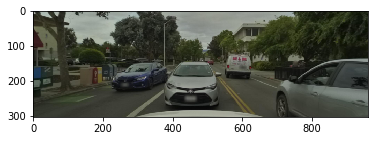

(1920, 1080)


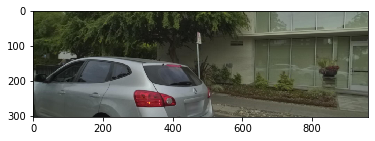

(1920, 1080)


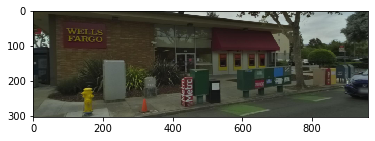

In [70]:
transform = transforms.Compose([
    transforms.CenterCrop((640, 1920)),
    transforms.Resize((320, 960)),
])

for cam in cams:
    cam_token = sample['data'][cam]
    sd_cam = dataset.get('sample_data', cam_token)
    cs_cam = dataset.get('calibrated_sensor', sd_cam['calibrated_sensor_token'])
    
    
    height = sd_cam['height']
    width = sd_cam['width']
    img_size = (width, height)
    print(img_size)
    
    im = Image.open(str(dataset.data_path / sd_cam["filename"]))
    im = transform(im)
    plt.imshow(np.asarray(im))
    plt.show()

CAM_FRONT
(1920, 1080)
CAM_FRONT_LEFT
(1920, 1080)
CAM_FRONT_RIGHT
(1920, 1080)
CAM_BACK
(1920, 1080)
CAM_BACK_LEFT
(1920, 1080)
CAM_BACK_RIGHT
(1920, 1080)


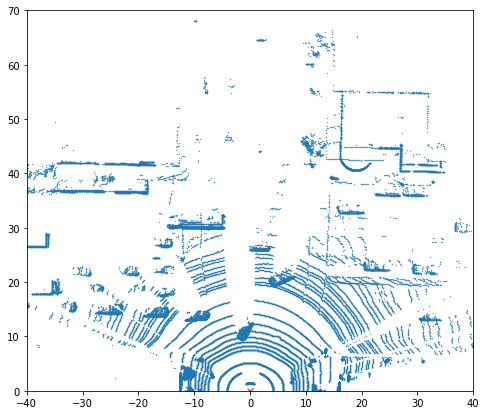

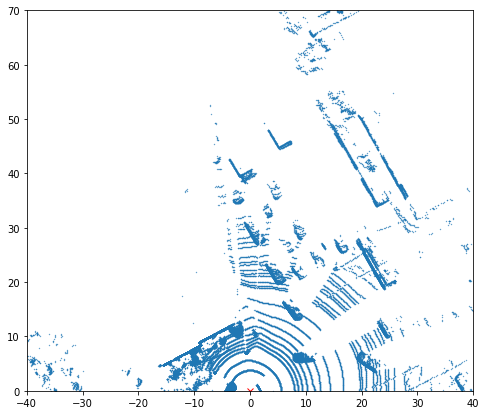

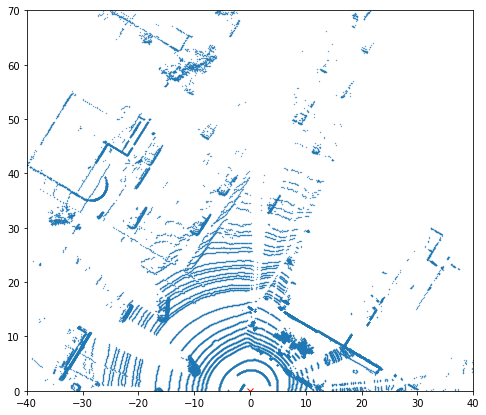

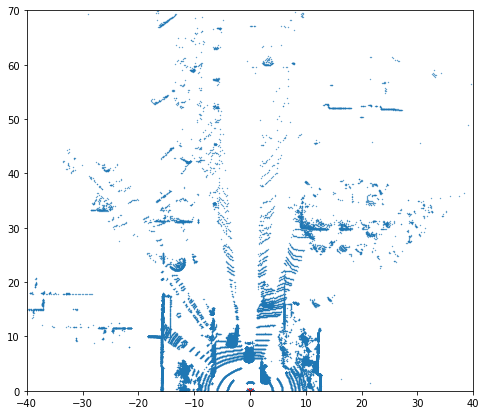

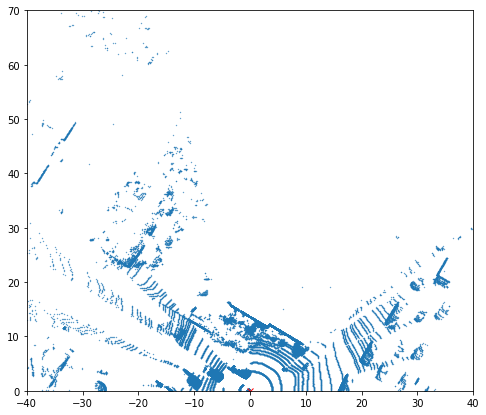

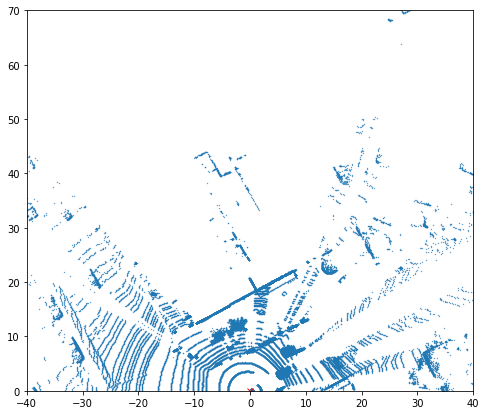

In [47]:
def plot_bev(points):
    _, ax = plt.subplots(1, 1, figsize=(8, 7))
    ax.scatter(points[0, :], points[1, :], s=0.1)
    ax.plot(0, 0, "x", color="red")
    ax.set_xlim(-40, 40)
    ax.set_ylim(0, 70)
    
def clip_points(points, xlimit=(-40, 40), ylimit=(0, 70), zlimit=(-3, 3)):
    clipped_points = points[:, (points[0, :] >= xlimit[0]) & 
                            (points[0, :] <= xlimit[1]) & 
                            (points[1, :] >= ylimit[0]) & 
                            (points[1, :] <= ylimit[1]) &
                            (points[2, :] >= zlimit[0]) &
                            (points[2, :] <= zlimit[1])]
    
    return clipped_points

for cam in cams:
    print(cam)
    cam_token = sample['data'][cam]
    sd_cam = dataset.get('sample_data', cam_token)
    cs_cam = dataset.get('calibrated_sensor', sd_cam['calibrated_sensor_token'])

    lidar_2_ego = transform_matrix(
        cs_lidar['translation'],
        Quaternion(cs_lidar['rotation']),
        inverse=False
    )

    ego_2_cam = transform_matrix(
        cs_cam['translation'],
        Quaternion(cs_cam['rotation']),
        inverse=True
    )
    
    cam_2_bev = Quaternion(axis=[1, 0, 0], angle=-np.pi / 2).transformation_matrix
    
    lidar_2_cam = ego_2_cam @ lidar_2_ego
    lidar_2_bevcam = cam_2_bev @ ego_2_cam @ lidar_2_ego

    points = view_points(pc.points[:3, :], lidar_2_bevcam, normalize=False)
    points = clip_points(points)
    plot_bev(points)

In [33]:
df = pd.DataFrame(np.swapaxes(points, 0, 1), columns=['x', 'y', 'z'])
df.describe()

,x,y,z
count,44725.000000,44725.000000,44725.000000
mean,-0.291573,16.010683,-0.879164
std,16.123068,14.090406,1.064540
min,-39.994129,0.000494,-2.998560
25%,-11.323919,3.465119,-1.781638
50%,-1.633903,12.575289,-1.097979
75%,12.582556,25.820094,-0.199091
max,39.997926,68.140070,2.964711


In [34]:
cloud = PyntCloud(df)
cloud.plot()

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.2915727392573145, 84.15075280726674, 3.56…

In [41]:
voxelgrid_id = cloud.add_structure("voxelgrid", size_x=0.1, size_y=0.1, size_z=0.2, regular_bounding_box=False)
voxelgrid = cloud.structures[voxelgrid_id]

In [44]:
occupancy = voxelgrid.get_feature_vector(mode='binary')
occupancy.shape

(800, 682, 30)

In [45]:
fill = np.zeros((800, 700, 30))
fill.shape

(800, 700, 30)

In [46]:
fill[:occupancy.shape[0], :occupancy.shape[1], :occupancy.shape[2]] = occupancy